In [1]:
import os
import time
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.io import loadmat

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Model 

In [4]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

class CSRNet(nn.Module):

    def __init__(self):

        super().__init__()
        self.frontend = nn.Sequential(*list(vgg16.features.children())[0:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )
    

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

In [5]:
model = CSRNet()
model = model.to(device)

# Dataset Pipeline

In [7]:
k_nearest = 3
beta = 0.3

def generate_density_map(img, points):

    img_width, img_height = img.size
    d_map_height = img_height // 8
    d_map_width = img_width // 8
    density_map = np.zeros((d_map_height, d_map_width), dtype=np.float32)
    
    if len(points) == 0:
        return density_map

    scaled_points = points / 8
    
    sigmas = []
    if len(scaled_points) > 1:
        distances = cdist(scaled_points, scaled_points)
        
        for i in range(len(scaled_points)):
            sorted_distances = np.sort(distances[i][distances[i] > 1e-6])
            
            if len(sorted_distances) >= k_nearest:
                d_k = sorted_distances[k_nearest - 1]
                sigma_i = beta * d_k
            else:
                sigma_i = beta * np.mean(sorted_distances) if len(sorted_distances) > 0 else 1.0
            sigmas.append(sigma_i)
    else:
        sigmas.append(4.0)
    
    sigmas = np.array(sigmas)
    
    for i, (x, y) in enumerate(scaled_points):
        if int(y) < d_map_height and int(x) < d_map_width:
            point_map = np.zeros_like(density_map)
            point_map[int(y), int(x)] = 1.0
            
            blurred_point_map = gaussian_filter(point_map, sigma=sigmas[i], mode='constant')

            density_map += blurred_point_map
    
    return density_map

In [8]:
class CustomDataset(Dataset):

    def __init__(self, img_folder_path, point_folder_path):
        self.img_folder_path = img_folder_path
        self.point_folder_path = point_folder_path
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    def __len__(self):
        return(len(os.listdir(self.img_folder_path)))


    def __getitem__(self, index):
        img_path = os.path.join(self.img_folder_path, f"IMG_{index+1}.jpg")
        point_path = os.path.join(self.point_folder_path, f"GT_IMG_{index+1}.mat")

        img = Image.open(img_path).convert("RGB")

        data = loadmat(point_path)
        point = data["image_info"][0][0][0][0][0]

        density_map = generate_density_map(img, points=point.astype(int))
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        img = self.transform(img)

        return img, density_map

In [9]:
train_dataset = CustomDataset("crowd_wala_dataset/train_data/images", "crowd_wala_dataset/train_data/ground_truth")
test_dataset = CustomDataset("crowd_wala_dataset/test_data/images", "crowd_wala_dataset/test_data/ground_truth")

In [10]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=4)

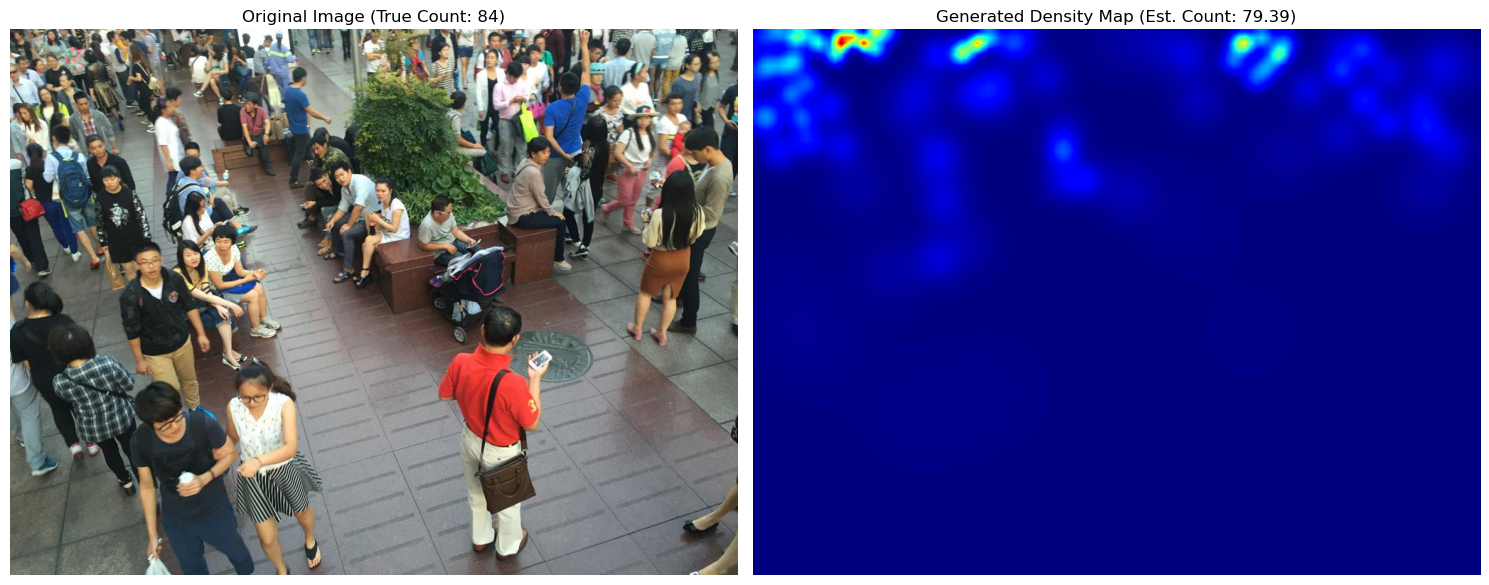

In [11]:
data = loadmat('crowd_wala_dataset/train_data/ground_truth/GT_IMG_40.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("crowd_wala_dataset/train_data/images/IMG_40.jpg").convert("RGB")

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)

upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Loss Fxn

In [12]:
learning_rate = 0.0001
epochs = 100

loss_fxn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [ ]:
start = time.time()
losses = []


for i in range(epochs):

    total_epoch_loss = 0
    count = 0

    for batch_image, batch_density_map in train_loader:

        batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)
        output = model(batch_image)

        loss = loss_fxn(output, batch_density_map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        print(f"Batch No.: {count}, Time Elapsed: {time.time() - start}")
    
        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f"Epoch: {i+1}, Loss: {avg_epoch_loss}")  

In [ ]:
plt.plot(range(1, 11), losses)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weights_CSRNet.pth')

In [6]:
model = CSRNet()
model = model.to(device)
model.load_state_dict(torch.load('model_weights_CSRNet.pth'))

<All keys matched successfully>

# Evaluation

In [ ]:
model.eval()

In [ ]:
total_loss = 0
count = 0

for batch_image, batch_density_map in test_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f"Avg Loss: {avg_loss}") 

In [ ]:
total_loss = 0
count = 0

for batch_image, batch_density_map in train_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / len(train_loader)
print(f"Avg Loss: {avg_loss}") 

torch.Size([3, 768, 1024])


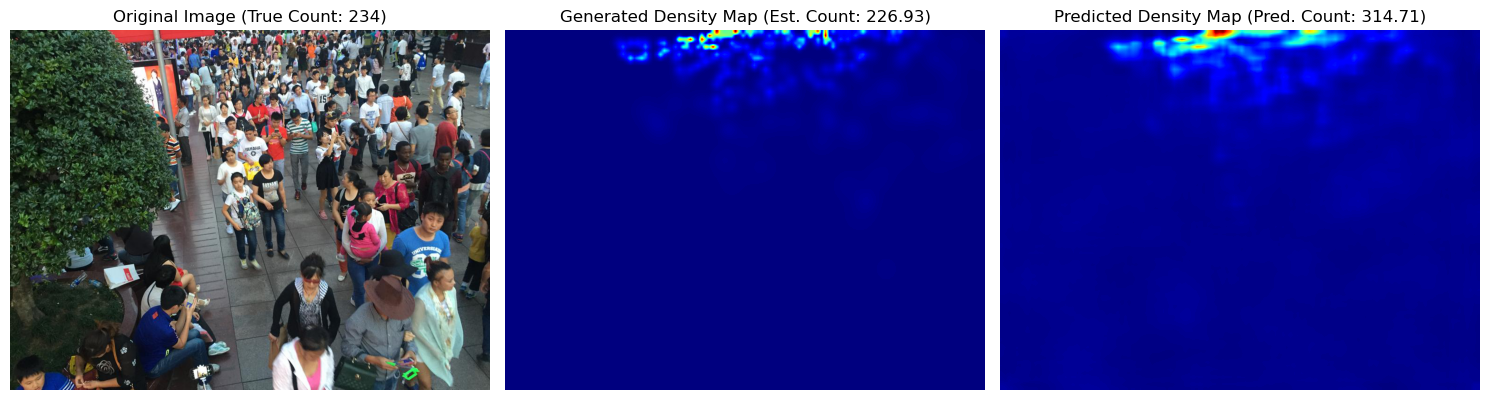

In [ ]:
data = loadmat('crowd_wala_dataset/train_data/ground_truth/GT_IMG_1.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("crowd_wala_dataset/train_data/images/IMG_1.jpg").convert("RGB")
width, height = img.size

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)
upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
with torch.no_grad():
    img_ = transform(img)
    img_ = img_.to(device)
    predicted_density_map = model(img_)
    upsampled_predicted_density_map = torch.nn.functional.interpolate(
        predicted_density_map.unsqueeze(0),
        size=(height, width),
        mode='bilinear',
        align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)
predicted_count = predicted_density_map.sum().item()


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(upsampled_predicted_density_map, cmap='jet')
plt.title(f'Predicted Density Map (Pred. Count: {predicted_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()